In [ ]:
import os, re, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter
import multiprocessing

In [ ]:
# scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

In [ ]:
# plotting defaults
try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except Exception:
    pass
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

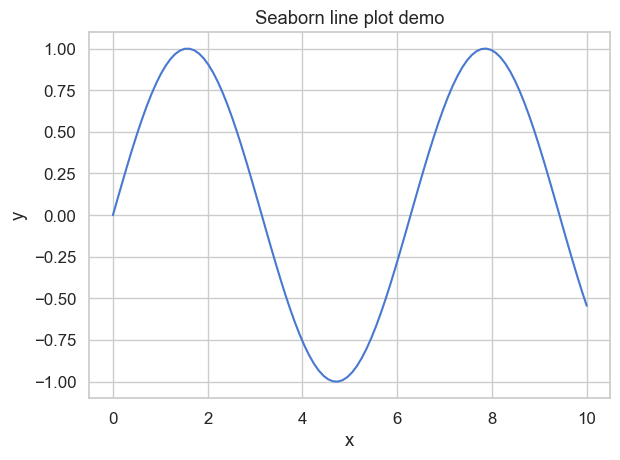

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# synthetic data (demo only)
x_demo = np.linspace(0, 10, 100)
y_demo = np.sin(x_demo)

demo_df = pd.DataFrame({"x": x_demo, "y": y_demo})

# seaborn plot (uses demo_df to avoid shadowing main df)
sns.lineplot(data=demo_df, x="x", y="y")
plt.title("Seaborn line plot demo")
plt.tight_layout()
plt.show()  # needed if running as a normal script

In [ ]:
# Data loading
try:
    BASE_DIR = Path(__file__).resolve().parent
except NameError:
    # __file__ is not defined inside some interactive environments
    BASE_DIR = Path.cwd()
DATA_PATH = BASE_DIR / "data"
csv_files = list(DATA_PATH.rglob("*.csv"))
print("CSV files found:", [str(p.relative_to(BASE_DIR)) for p in csv_files])

if not csv_files:
    raise FileNotFoundError(f"No CSV files found under {DATA_PATH}. Place your CSV(s) in this folder.")

# Prefer Resume.csv if present
preferred = [p for p in csv_files if p.name.lower() == "resume.csv"]
csv_to_use = preferred[0] if preferred else csv_files[0]

df = pd.read_csv(csv_to_use)
print("Loaded:", csv_to_use)
print(df.shape)
print(df.head(3))

CSV files found: ['data\\processed\\resumes_processed.csv']
Loaded: C:\Users\DARSHAN\OneDrive\Desktop\resume-analysis\data\processed\resumes_processed.csv
(2484, 9)
         id                                         resume_str  \
0  16852973  HR ADMINISTRATOR/MARKETING ASSOCIATE\n\nHR ADM...   
1  22323967  HR SPECIALIST, US HR OPERATIONS       Summary ...   
2  33176873  HR DIRECTOR       Summary      Over 20 years e...   

                                         resume_html category  \
0  <div class="fontsize fontface vmargins hmargin...       HR   
1  <div class="fontsize fontface vmargins hmargin...       HR   
2  <div class="fontsize fontface vmargins hmargin...       HR   

                                        resume_clean  \
0  hr administrator marketing associate hr admini...   
1  hr specialist, us hr operations summary versat...   
2  hr director summary over 20 years experience i...   

                                         skills_list  num_skills  \
0  ['r', 'market

In [ ]:
# Detect resume text column robustly
candidate_exact = [
    "resume", "resume_text", "text", "resumeheadline", "resume_headline",
    "summary", "content", "raw_text", "cv", "profile", "description"
]

resume_col = None
lower_map = {c.lower(): c for c in df.columns}

# 1) Exact name matches (case-insensitive)
for name in candidate_exact:
    if name in lower_map:
        resume_col = lower_map[name]
        break

# 2) Substring matches
if resume_col is None:
    keywords = ["resume", "cv", "text", "profile", "summary", "description"]
    contains = [c for c in df.columns if any(k in c.lower() for k in keywords)]
    if contains:
        resume_col = contains[0]

# 3) Heuristic fallback: longest average string length among object dtype columns
if resume_col is None:
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    if obj_cols:
        avg_lens = {c: df[c].astype(str).str.len().mean() for c in obj_cols}
        if avg_lens:
            resume_col = max(avg_lens, key=avg_lens.get)

if resume_col is None:
    raise ValueError(
        f"Cannot find resume text column in dataset. Available columns: {list(df.columns)}"
    )

print(f"Using resume text column: '{resume_col}'")

Using resume text column: 'resume_str'


In [ ]:
# Quick data inspection
df.info()
df.describe(include='all').T
# show columns and missing %
cols = df.columns.tolist()
missing = df.isna().mean().sort_values(ascending=False)
missing[missing>0].head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                2484 non-null   int64  
 1   resume_str        2483 non-null   object 
 2   resume_html       2484 non-null   object 
 3   category          2484 non-null   object 
 4   resume_clean      2483 non-null   object 
 5   skills_list       2484 non-null   object 
 6   num_skills        2484 non-null   int64  
 7   years_experience  954 non-null    float64
 8   education_level   2430 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 174.8+ KB


years_experience    0.615942
education_level     0.021739
resume_str          0.000403
resume_clean        0.000403
dtype: float64

In [ ]:
#Normalize column names
df.columns = [re.sub(r'\s+','_',c.strip()).lower() for c in df.columns]
df.rename(columns=lambda x: x.lower(), inplace=True)
df.columns.tolist()

['id',
 'resume_str',
 'resume_html',
 'category',
 'resume_clean',
 'skills_list',
 'num_skills',
 'years_experience',
 'education_level']

In [ ]:
# Parse/clean resume text (lowercase, remove emails, urls, phone)
email_re = re.compile(r'\S+@\S+')
phone_re = re.compile(r'(\+?\d[\d\-\s]{7,}\d)')
url_re = re.compile(r'http\S+|www\.\S+')

def clean_text(text):
    text = str(text)
    text = text.replace('\r',' ').replace('\n',' ')
    text = email_re.sub(' ', text)
    text = phone_re.sub(' ', text)
    text = url_re.sub(' ', text)
    text = re.sub(r'[^A-Za-z0-9\.\,\s\(\)\-\+]', ' ', text)  # allow punctuation
    text = re.sub(r'\s{2,}',' ', text)
    return text.strip().lower()

resume_col = None
for c in df.columns:
    if 'resume' in c:
        resume_col = c
        break
if resume_col is None:
    raise ValueError("Cannot find resume text column in dataset.")
df['resume_clean'] = df[resume_col].apply(clean_text)
df['resume_clean'].head()

0    hr administrator marketing associate hr admini...
1    hr specialist, us hr operations summary versat...
2    hr director summary over 20 years experience i...
3    hr specialist summary dedicated, driven, and d...
4    hr manager skill highlights hr skills hr depar...
Name: resume_clean, dtype: object

In [ ]:
# Extract features: skills, education, years experience, job titles (basic heuristics)
# Common skill keywords can be expanded
SKILL_KEYWORDS = [
    'python','sql','excel','tableau','power bi','powerbi','r','java','c++','c#',
    'machine learning','deep learning','pandas','numpy','scikit-learn','keras','tensorflow',
    'nlp','natural language processing','spark','hadoop','aws','azure','gcp','docker','kubernetes',
    'communication','leadership','management','sales','marketing'
]

def extract_skills(text, keywords=SKILL_KEYWORDS):
    found=[]
    t = text.lower()
    for k in keywords:
        if k in t:
            found.append(k)
    return list(set(found))

df['skills_list'] = df['resume_clean'].apply(lambda x: extract_skills(x))
df['num_skills'] = df['skills_list'].apply(len)

# Basic years of experience extraction - find patterns like "5 years" or "5+ years"
years_re = re.compile(r'(\b\d{1,2}\+?\s*(?:years|yrs|year)\b)')
def extract_years(text):
    m = years_re.findall(text.lower())
    if not m:
        return np.nan
    # return largest number found
    nums = []
    for match in m:
        num = re.search(r'\d{1,2}', match)
        if num:
            nums.append(int(num.group()))
    if nums:
        return max(nums)
    return np.nan

df['years_experience'] = df['resume_clean'].apply(extract_years)

# Basic education extraction
EDU_KEYWORDS = ['phd','doctor','master','m.sc','msc','mtech','mba','bachelor','b.sc','btech','b.e','bs','ba']
def extract_education(text):
    t = text.lower()
    for k in EDU_KEYWORDS:
        if k in t:
            return k
    return np.nan

df['education_level'] = df['resume_clean'].apply(extract_education)

df[['skills_list','num_skills','years_experience','education_level']].head(10)

,skills_list,num_skills,years_experience,education_level
0,"[sales, leadership, marketing, aws, management...",6,15.0,bs
1,"[communication, sales, marketing, management, r]",5,NaN,master
2,"[excel, leadership, marketing, management, r]",5,20.0,master
3,"[excel, communication, management, r]",4,20.0,bs
4,"[excel, leadership, aws, management, r]",5,NaN,bachelor
5,"[excel, management, r]",3,NaN,bs
6,"[management, leadership, r]",3,NaN,bachelor
7,"[communication, aws, management, r]",4,NaN,mba
8,"[excel, communication, leadership, aws, manage...",6,15.0,bachelor
9,"[management, aws, r]",3,NaN,bachelor


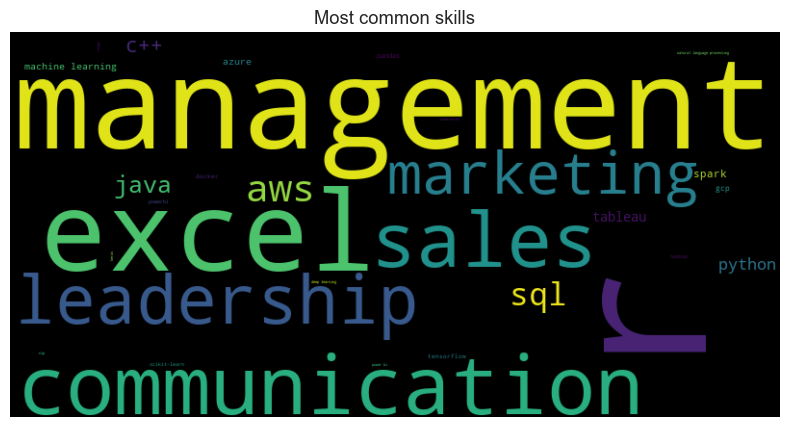

In [ ]:
# Wordcloud of skills / most common skills
skill_counts = Counter([s for skills in df['skills_list'] for s in skills])
skill_counts.most_common(30)
# Wordcloud
wc = WordCloud(width=800, height=400).generate_from_frequencies(skill_counts)
plt.figure(figsize=(12,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Most common skills")
plt.show()

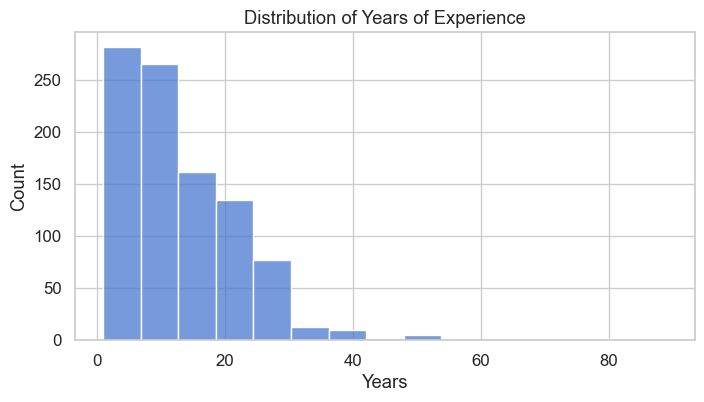

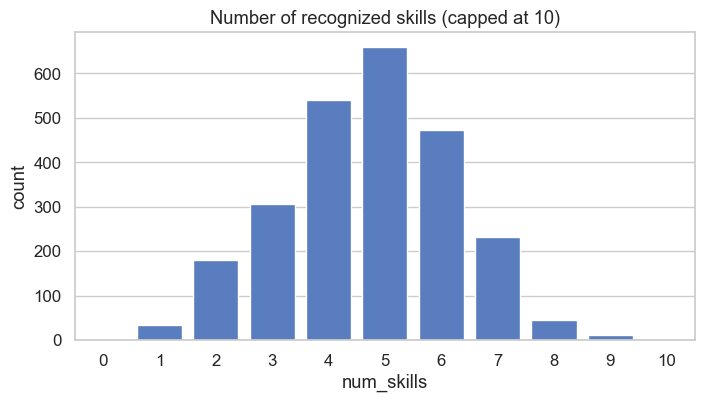

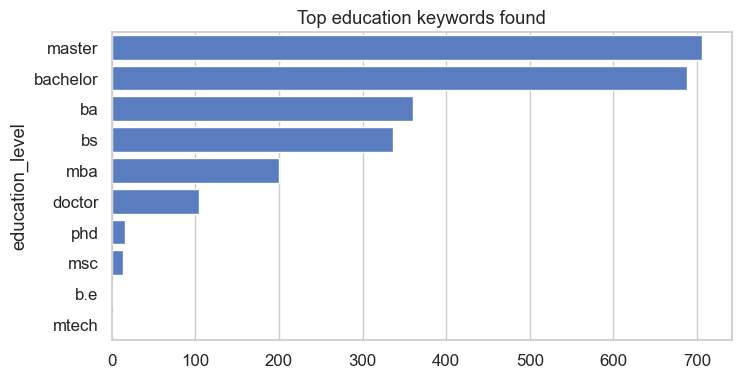

In [ ]:
# EDA: numeric summaries & plots
# Distribution of years_experience
plt.figure(figsize=(8,4))
sns.histplot(df['years_experience'].dropna(), bins=15, kde=False)
plt.title("Distribution of Years of Experience")
plt.xlabel("Years")
plt.show()

# Num skills distribution
plt.figure(figsize=(8,4))
sns.countplot(x='num_skills', data=df[df['num_skills']<=10])  # cap for visibility
plt.title("Number of recognized skills (capped at 10)")
plt.show()

# Education counts
plt.figure(figsize=(8,4))
edu_counts = df['education_level'].value_counts().head(10)
sns.barplot(x=edu_counts.values, y=edu_counts.index)
plt.title("Top education keywords found")
plt.show()

In [ ]:
# Interactive plotly example (skills vs years)
# scatter years_experience vs num_skills
df_plot = df.dropna(subset=['years_experience'])
fig = px.scatter(df_plot, x='years_experience', y='num_skills', hover_data=['skills_list'], title='Years Experience vs Number of Skills')
fig.show()

In [ ]:
# Statistical test examples
# Hypothesis example: Candidates with a Masters/MBA have more years experience than Bachelor's
# create groups
group_masters = df[df['education_level'].str.contains('m', na=False)]['years_experience'].dropna()
group_bachelors = df[df['education_level'].str.contains('b', na=False)]['years_experience'].dropna()

from scipy.stats import ttest_ind
if len(group_masters)>10 and len(group_bachelors)>10:
    tstat, pval = ttest_ind(group_masters, group_bachelors, equal_var=False, nan_policy='omit')
    print("t-stat:", tstat, "p-value:", pval)
else:
    print("Not enough samples for robust t-test. sizes:", len(group_masters), len(group_bachelors))

t-stat: 1.51398589867144 p-value: 0.13042319952146195


In [ ]:
# Prepare data for predictive modeling (example: predict role/category or label if available)
# Some datasets include a 'category' or 'tag' column; adapt accordingly.
target_col = None
for c in df.columns:
    if c in ['category','job_category','label','target','designation']:
        target_col = c
        break

# If dataset has no target, you can create a heuristic target (e.g., classify into 'data_science' vs 'non_data')
# Example: create binary label whether resume contains 'data' or 'machine learning'
if target_col is None:
    df['is_data_role'] = df['resume_clean'].apply(lambda x: 1 if ('data' in x or 'machine learning' in x or 'ml ' in x) else 0)
    target_col = 'is_data_role'

print("Using target:", target_col, "counts:\n", df[target_col].value_counts())

Using target: category counts:
 category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64


In [ ]:
# Modeling pipeline: TF-IDF + Logistic Regression
# Robust target encoding and pipeline
X = df['resume_clean']
y_raw = df[target_col]

if pd.api.types.is_numeric_dtype(y_raw):
    y = y_raw.astype('Int64')
else:
    y_coerced = pd.to_numeric(y_raw, errors='coerce')
    if y_coerced.notna().mean() > 0.9:
        y = y_coerced.astype('Int64')
    else:
        le = LabelEncoder()
        mask_non_null = y_raw.notna()
        y_encoded = pd.Series(index=y_raw.index, dtype='float')
        y_encoded[mask_non_null] = le.fit_transform(y_raw[mask_non_null])
        y = y_encoded.astype('Int64')

# Drop NAs in y and align X
mask = y.notna()
X = X[mask]
y = y[mask].astype(int)

# Class checks and conditional stratification
class_counts = y.value_counts()
print("Class counts:\n", class_counts)
if class_counts.shape[0] < 2:
    raise ValueError("Need at least 2 classes to train a classifier. Found: " + str(class_counts.to_dict()))

use_stratify = (class_counts.min() >= 2)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y if use_stratify else None,
    random_state=42
)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Class counts:
 20    120
9     120
1     118
10    118
15    118
0     118
16    118
17    117
6     117
22    116
7     115
18    115
12    115
11    112
21    111
19    110
13    107
4     103
23    102
3      97
14     96
2      63
5      36
8      22
Name: count, dtype: int64
Accuracy: 0.6498993963782697
              precision    recall  f1-score   support

           0       0.62      0.83      0.71        24
           1       0.35      0.50      0.41        24
           2       1.00      0.38      0.56        13
           3       0.60      0.16      0.25        19
           4       0.46      0.29      0.35        21
           5       0.00      0.00      0.00         7
           6       0.85      0.71      0.77        24
           7       0.79      0.65      0.71        23
           8       0.00      0.00      0.00         4
           9       0.54      0.92      0.68        24
          10       0.81      0.71      0.76        24
          11       0.77      0.77      0.

c:\Users\DARSHAN\OneDrive\Desktop\resume-analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\DARSHAN\OneDrive\Desktop\resume-analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\DARSHAN\OneDrive\Desktop\resume-analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Feature importance (top TF-IDF coefficients)
# show top features for positive class
clf = pipeline.named_steps['clf']
tfidf = pipeline.named_steps['tfidf']
feature_names = tfidf.get_feature_names_out()
coefs = clf.coef_[0]
top_pos = np.argsort(coefs)[-30:]
top_neg = np.argsort(coefs)[:30]

print("Top positive features:", feature_names[top_pos][::-1])
print("Top negative features:", feature_names[top_neg])

Top positive features: ['accounting' 'accountant' 'financial' 'accounts' 'tax' 'payroll'
 'entries' 'ledger' 'bank' 'payable' 'general ledger'
 'financial statements' 'reconciliations' 'statements' 'cash' 'journal'
 'accounts payable' 'journal entries' 'general' 'end' 'month end'
 'accountant summary' 'balance' 'account' 'receivable' 'reconciled'
 'reports' 'monthly' 'reconciliation' 'accounts receivable']
Top negative features: ['sales' 'customer' 'service' 'marketing' 'director' 'manager' 'team'
 'engineering' 'customer service' 'product' 'students' 'media' 'equipment'
 'customers' 'high' 'school' 'technology' 'calls' 'project' 'social'
 'design' 'store' 'developed' 'safety' 'products' 'quality' 'public'
 'market' 'managed' 'services']


In [ ]:
#Save processed data and artifacts
processed_path = DATA_PATH / "processed"
processed_path.mkdir(exist_ok=True)
df.to_csv(processed_path / "resumes_processed.csv", index=False)

# Save model and label encoder
import joblib
model_data = {
    'pipeline': pipeline,
    'label_encoder': le if 'le' in locals() else None,
    'target_col': target_col
}
joblib.dump(model_data, processed_path / "resume_classifier_lr.joblib")

['C:\\Users\\DARSHAN\\OneDrive\\Desktop\\resume-analysis\\data\\processed\\resume_classifier_lr.joblib']

In [ ]:
#Statistical rigor & suggestions for hypothesis testing
# Chi-Square Test: Education vs Role/Target

from scipy.stats import chi2_contingency

# create contingency table
ct = pd.crosstab(df['education_level'].fillna('other'), df[target_col])

# perform chi-square test
chi2, p, dof, ex = chi2_contingency(ct)

print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("p-value:", p)

# interpret the p-value
if p < 0.05:
    print("✅ Significant relationship between education level and role (reject H0).")
else:
    print("❌ No significant relationship (fail to reject H0).")

Chi-square statistic: 648.5868788166183
Degrees of freedom: 276
p-value: 4.969834623252063e-32
✅ Significant relationship between education level and role (reject H0).


In [ ]:
#Evaluation metrics for model(s)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1_macro')
print(scores.mean(), scores.std())

0.5803125592803676 0.035598690949674786
